In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
import numpy as np
import xgboost as xgb

### Load Dataset

In [172]:
df = pd.read_csv('data/candy_production.csv', parse_dates=['observation_date'])

In [173]:
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


### Rename columns

In [174]:
df = df.rename(columns={'observation_date': 'date', 'IPG3113N': 'production'})

In [175]:
df.head()

,date,production
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [176]:
df = df.set_index('date')

In [177]:
df.head()

,production
date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [178]:
df.describe()

,production
count,548.000000
mean,100.662524
std,18.052931
min,50.668900
25%,87.862475
50%,102.278550
75%,114.691900
max,139.915300


### There us no missing value in the dataset

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1972-01-01 to 2017-08-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   production  548 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


### Candy Production Overview

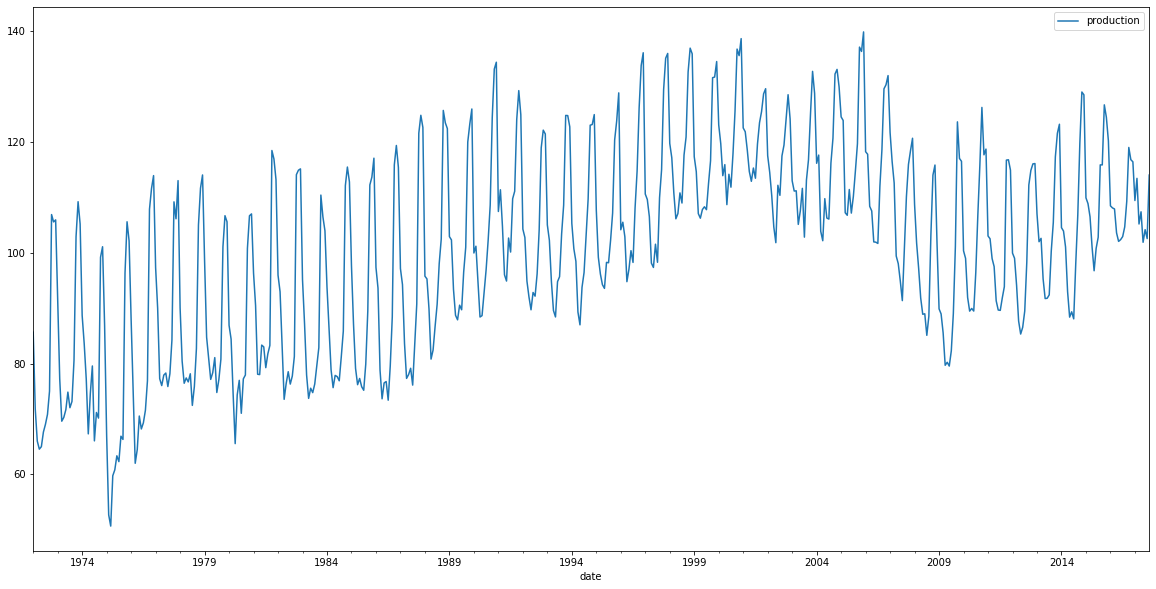

In [183]:
df.plot()

### Production is normal distribution with a little right-skewed

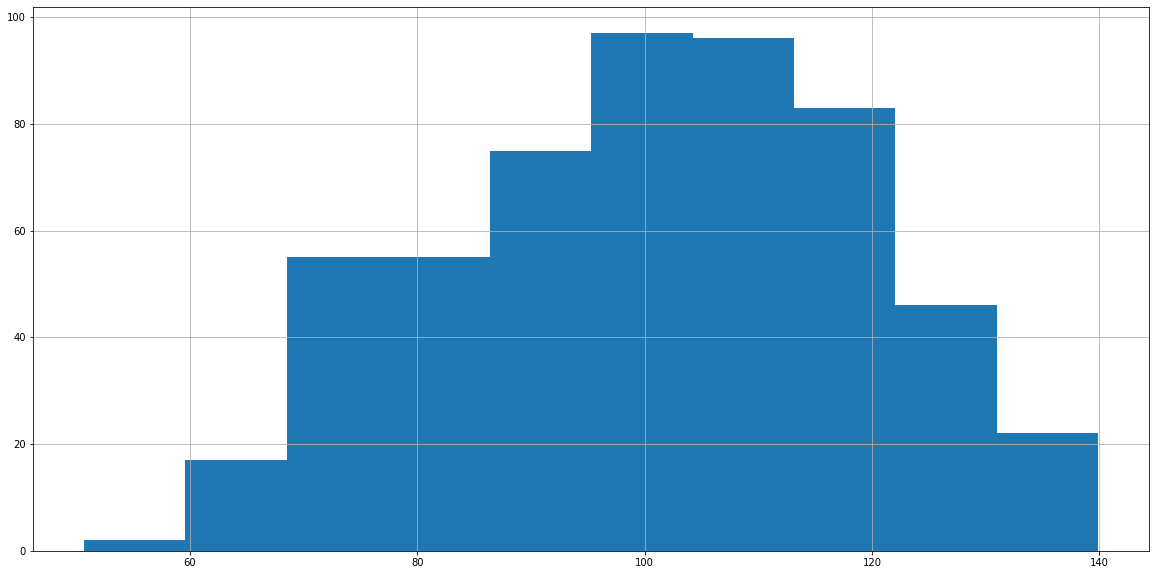

In [182]:
plt.hist(df['production'])
plt.grid(True)

In [132]:
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['month'] = df.index.month

### The fourth Quater has the best sale. Maybe it is due to Thanksgiving and Christmas holidays.

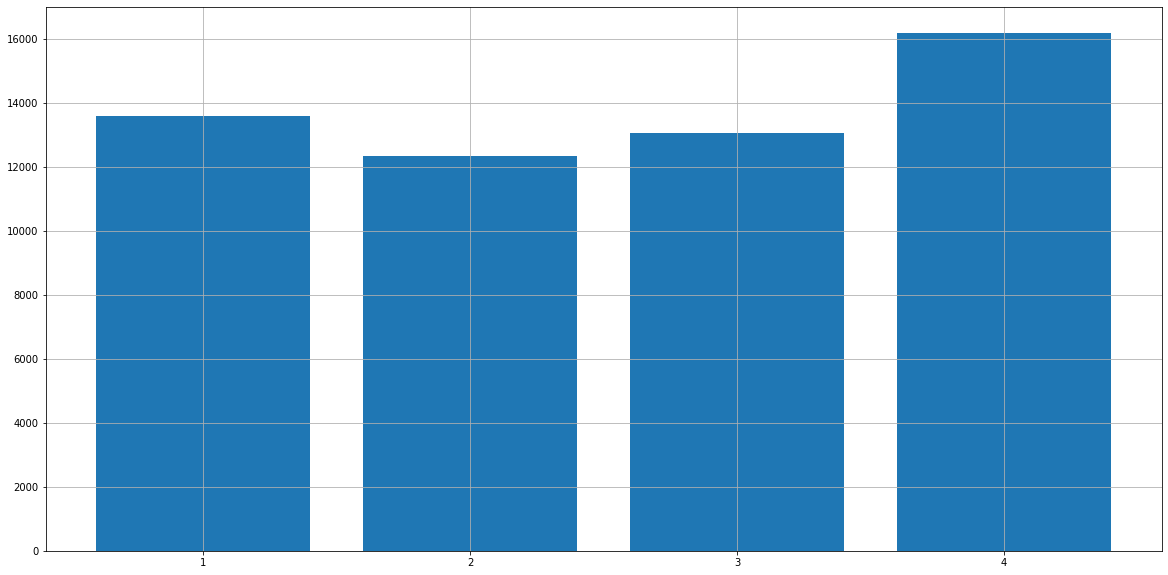

In [133]:
quarter_amount = df.groupby('quarter')['production'].sum().reset_index().set_index('quarter')
plt.bar(quarter_amount.index.astype(str), quarter_amount['production'])
plt.grid(True)

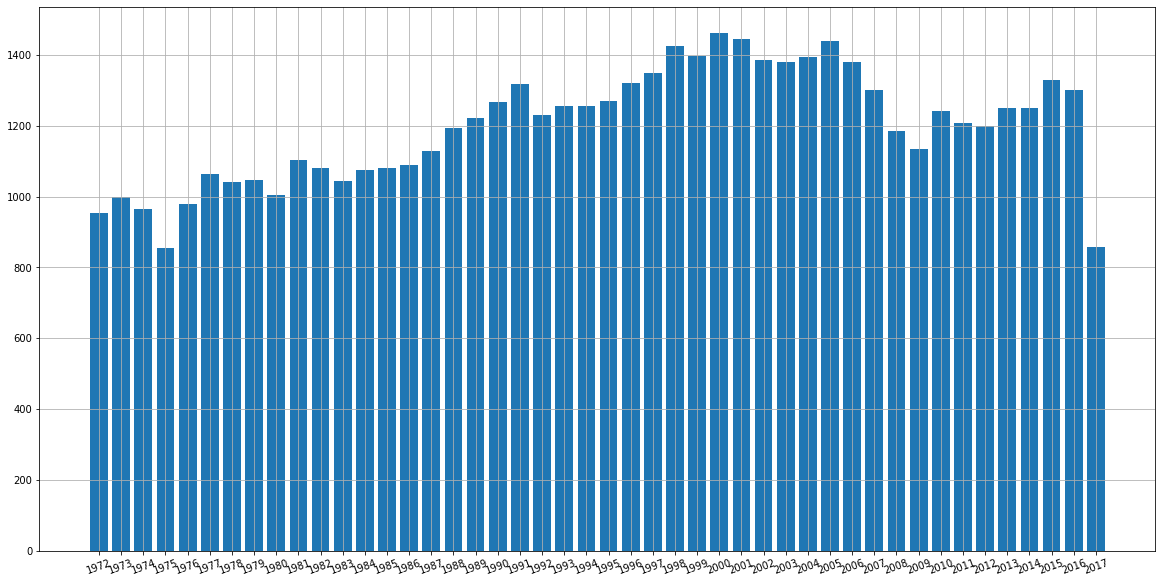

In [134]:
plt.rcParams['figure.figsize'] = (20,10)
year_amount = df.groupby('year')['production'].sum().reset_index().set_index('year')
plt.bar(year_amount.index.astype(str), year_amount['production'])
plt.xticks(rotation=20)
plt.grid(True)

### There is no strong correlation between production and other features

In [138]:
df.corr()

,amount,quarter,year,month
amount,1.000000,0.432218,0.513951,0.425753
quarter,0.432218,1.000000,-0.014050,0.971556
year,0.513951,-0.014050,1.000000,-0.014564
month,0.425753,0.971556,-0.014564,1.000000


In [69]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
        scale - Z value, 1.96 = 95% of confidence interval

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "y", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "b--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "b--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

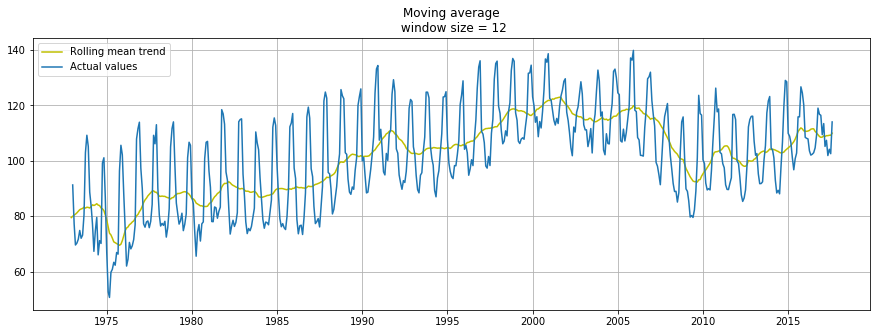

In [140]:
production = df[['production']]
plotMovingAverage(production, 12)

### Detect outlier by using average mean.

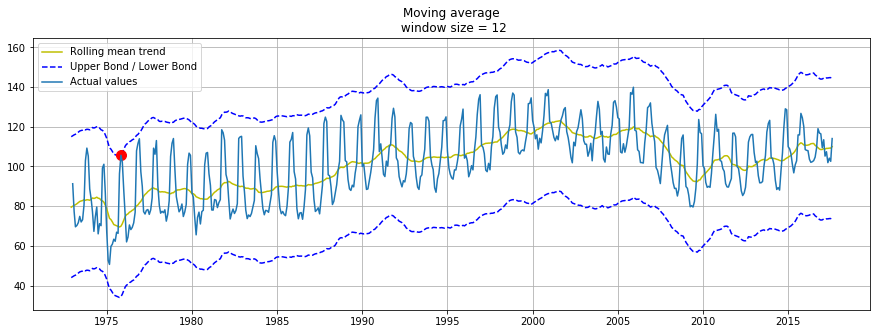

In [106]:
plotMovingAverage(production, 12, plot_intervals=True, plot_anomalies=True)

### Below graphs indicates that production has strong yearly correlation but not quarterly

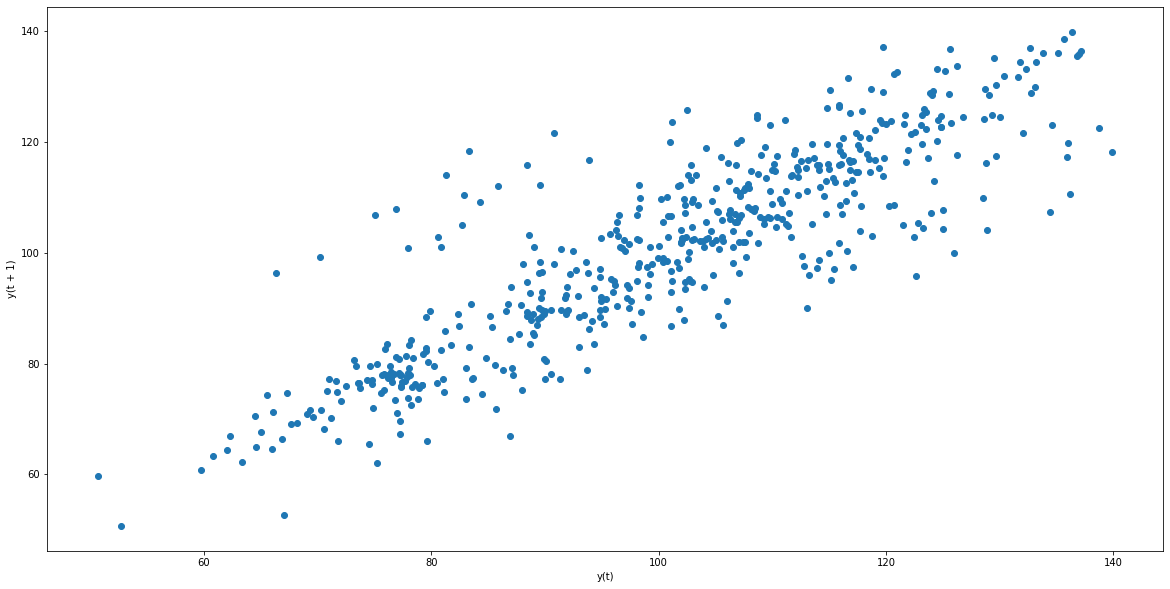

In [141]:
from pandas.plotting import lag_plot
lag_plot(production, lag=1)

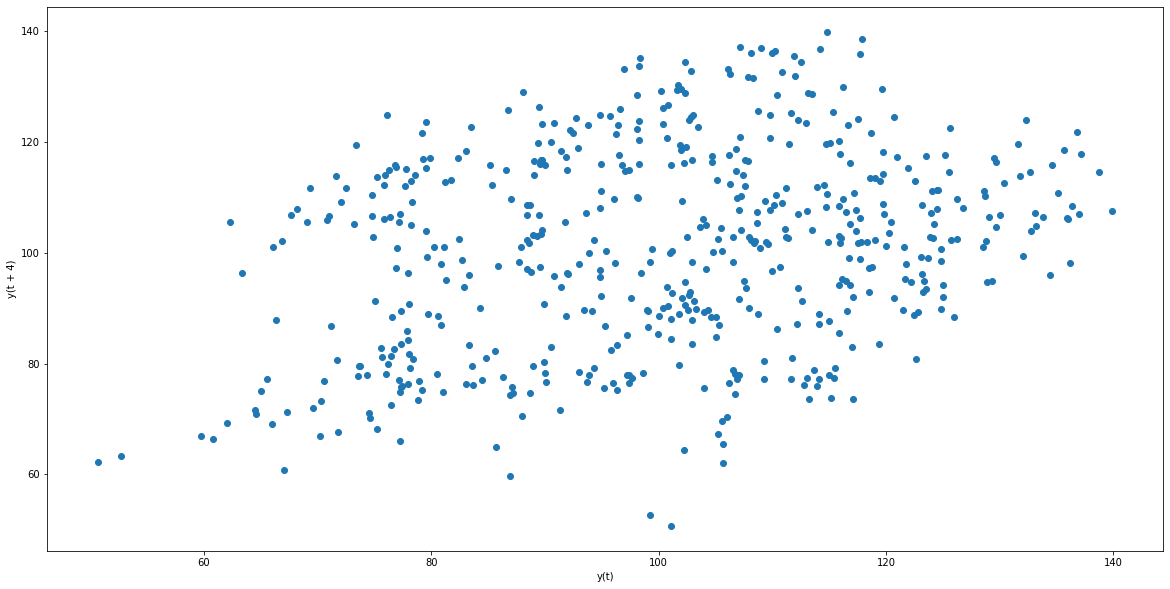

In [142]:
lag_plot(production, lag=4)

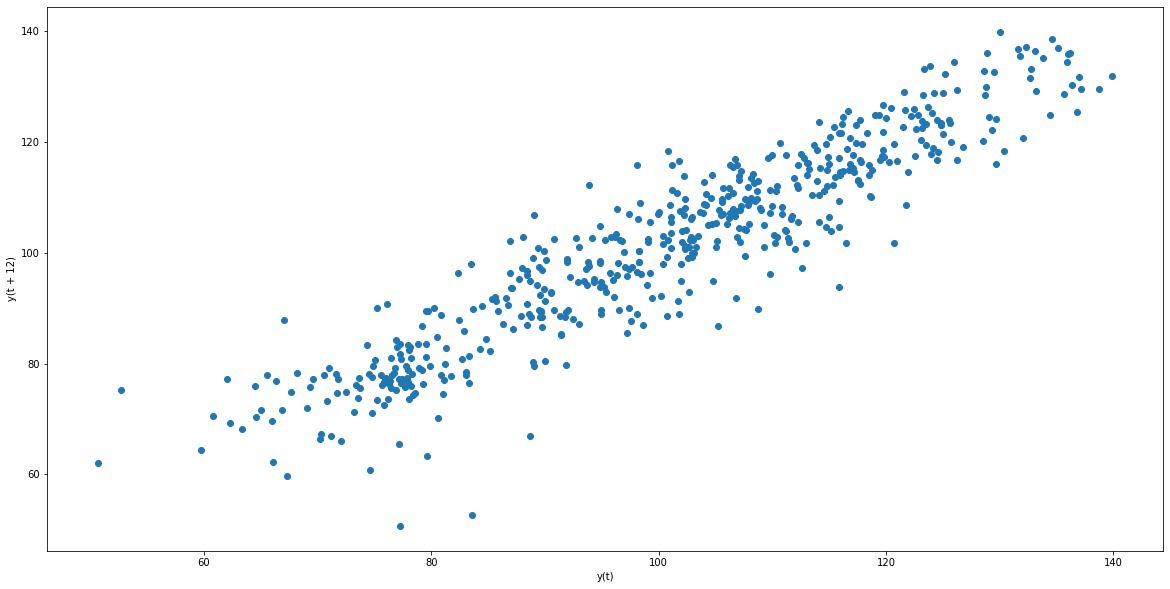

In [143]:
lag_plot(production, lag=12)

(0, 25)

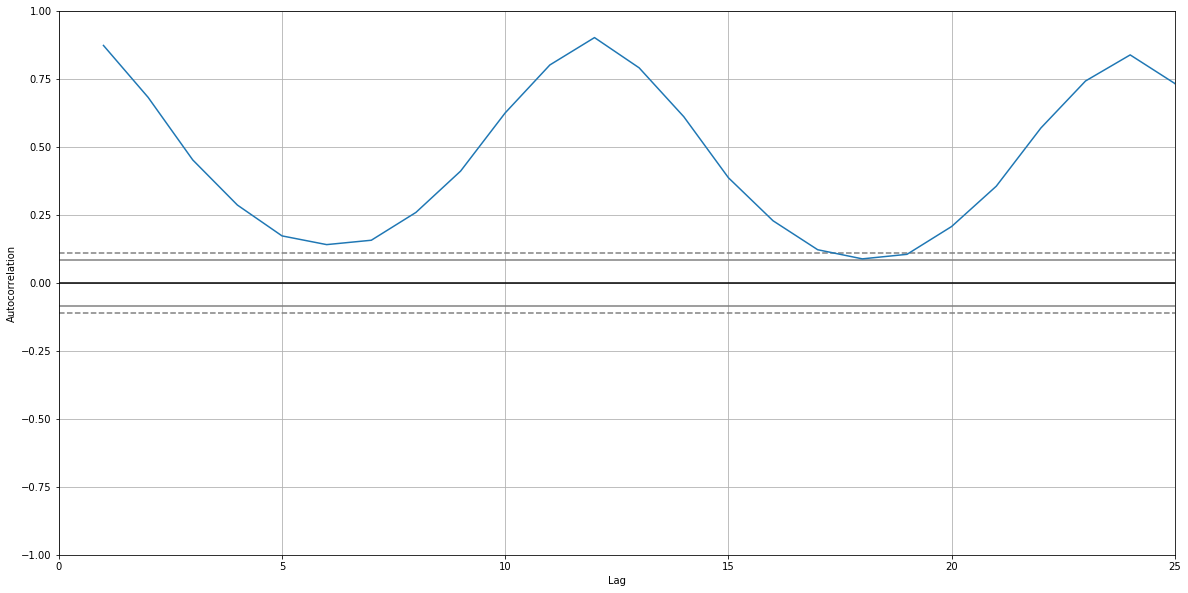

In [144]:
pd.plotting.autocorrelation_plot(production).set_xlim(0, 25)

In [150]:
production_train = df.loc[df.index < '2008-12-01'].copy()
production_test = df.loc[df.index >= '2008-12-01'].copy()

In [151]:
def create_time_series_features(df, label):

    df['lag_month'] = df['amount'].shift(1)
    df['lag_year'] = df['amount'].shift(12)
    df['lag_2year'] = df['amount'].shift(24)

    df['rolling_mean_month'] = df['amount'].rolling(window=1).mean()
    df['rolling_sum_month'] = df['amount'].rolling(window=1).sum()
    df['rolling_max_month'] = df['amount'].rolling(window=1).max()
    df['rolling_min_month'] = df['amount'].rolling(window=1).min()
    df['rolling_std_month'] = df['amount'].rolling(window=1).std()

    df['rolling_mean_yearly'] = df['amount'].rolling(window=12).mean()
    df['rolling_sum_yearly'] = df['amount'].rolling(window=12).sum()
    df['rolling_max_yearly'] = df['amount'].rolling(window=12).max()
    df['rolling_min_yearly'] = df['amount'].rolling(window=12).min()
    df['rolling_std_yearly'] = df['amount'].rolling(window=12).std()

    X = df.loc[:, (df.columns != label) & (df.columns != 'date')]
    return X, df[label]

In [152]:
X_train, y_train = create_time_series_features(production_train, label='production')
X_test, y_test = create_time_series_features(production_test, label='production')

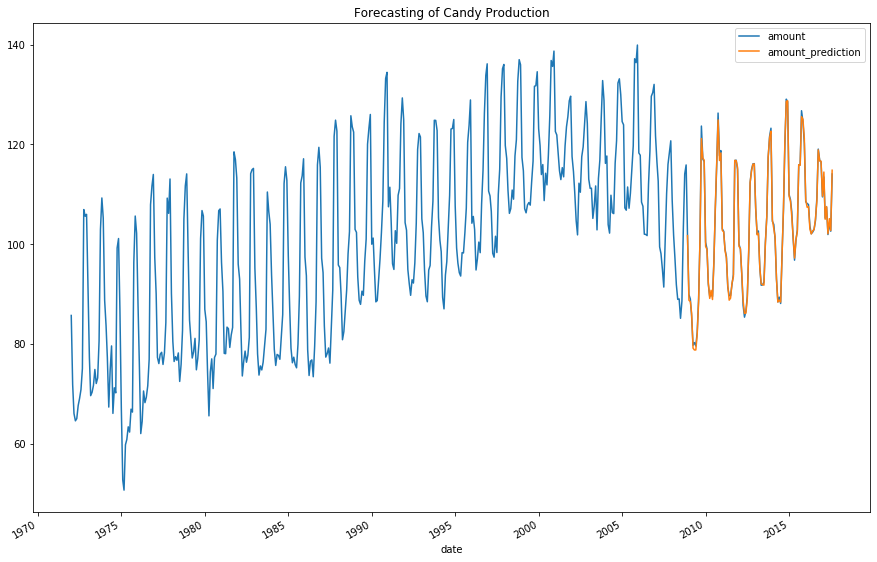

In [153]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)

production_test['production_prediction'] = model.predict(X_test)
production_all = pd.concat([production_test, production_train], sort=False)

graph = production_all[['production', 'production_prediction']].plot(figsize=(15, 10))
plt.title('Forecasting of Candy Production')
plt.show()

In [154]:
print('Mean Squared Error:{}'.format(mean_squared_error(production_test['production'],
                                                        production_test['production_prediction'])))
print('Mean Absolute Error:{}'.format(mean_absolute_error(production_test['production'],
                                                              production_test['production_prediction'])))

Mean Squared Error:0.3239758131874296
Mean Absolute Error:0.4282815776134681
